# NZU price data scraping

This notebook was created as part of a web-scraping exercise, gathering historical data on the price of NZUs from [Carbon News](https://www.carbonnews.co.nz/), the [Jarden NZ Market Report](https://www.carbonnews.co.nz/tag.asp?tag=Jarden+NZ+Market+Report) section to be more specific.

The initial one-off scrape is implemented in section 3 below, with some reusable code chunks loaded from [scraping_functions.py](./scraping_functions.py), and some scrapped bits of code left in section 4. 

Sections 1 and 2 were subsequently prepended for (i) more convenient updating of the scraped data and (ii) plotting it alongside [theecanmole's dataset](https://github.com/theecanmole/nzu). 

In [1]:
url="https://www.carbonnews.co.nz/"
datafile='nzu_price_raw_data.csv'

## Data update

Run the cell below to update the datafile. The update will scrape the [Jarden NZ Market Report](https://www.carbonnews.co.nz/tag.asp?tag=Jarden+NZ+Market+Report) but not the archive, and automatically append the new price values to the datafile.

In [2]:
from scraping_functions import update_data
outcome = update_data(datafile)
print(outcome)

Appended 1 rows.


## Time-series plot

Run the cell below to replot ours and theecanmole's data files.   

(0.0, 92.845)

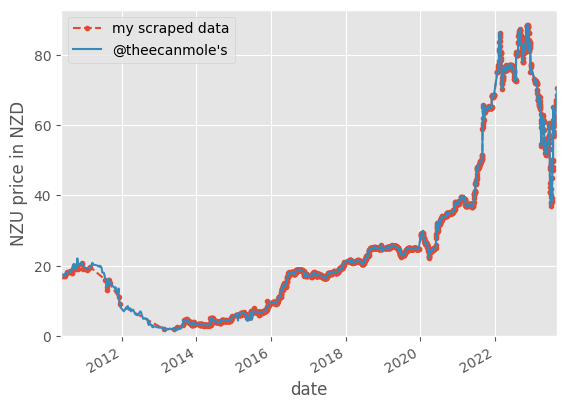

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime
import numpy as np

my_df = pd.read_csv(datafile, index_col='date', parse_dates=[0])
mole_df = pd.read_csv('theecanmole_price_data.csv', index_col='date', parse_dates=[0])

plt.style.use('ggplot')

fig = plt.figure(1)

#ax = plt.subplot(3,1,(2,3))
ax = plt.subplot()
my_df.plot(ax=ax, marker='.', linestyle='--')
mole_df.plot(ax = ax).get_figure()
ax.legend(['my scraped data','@theecanmole\'s'])
ax.set_ylabel('NZU price in NZD')
ax.set_xlim(my_df.index.min(), my_df.index.max())
ax.set_ylim(0)

#ax2 = plt.subplot(3,1,(1))
#fig.tight_layout()

#mole_density = mole_df.index.year.value_counts()
#my_density = my_df.index.year.value_counts()
#mole_density.plot.bar(ax = ax2)
#mole_df['year'] = mole_df.index.year
#mole_df['year'].plot.hist(ax=ax2,bins=15)
#my_df['year'] = my_df.index.year
#my_df['year'].plot.hist(ax = ax2, alpha=0.5, bins = 23)
#mole_df['year'] = mole_df.index.year
#mole_df['year'].plot.hist(ax = ax2, alpha=0.5, bins = 23)
#ax2.set_xlim(my_df['year'].min()+0., my_df['year'].max()+1)
#ax2.set_xlim(2010,2023)
#ax = fig.add_subplot(2,1,2)

In [4]:
fig.savefig('nzu_price.svg')

## Initial scraping

This section contains 

In [5]:
import requests
from bs4 import BeautifulSoup
import time
import csv

To scrape the data using a Python package called Beautiful Soup, we need to first use Python's `request` module to get the entire HTML source of a given website. We are interested in two URLs:
```
https://www.carbonnews.co.nz/tag.asp?tag=Jarden+NZ+Market+Report
https://www.carbonnews.co.nz/tagarchive.asp?tag=Jarden+NZ+Market+Report
```
So we will parse them separately and store as two beautiful soups.

In [6]:
page = requests.get(url+"tag.asp?tag=Jarden+NZ+Market+Report")
soup = BeautifulSoup(page.content, "html.parser")
time.sleep(2)
page = requests.get(url+"tagarchive.asp?tag=Jarden+NZ+Market+Report")
soup2 = BeautifulSoup(page.content, "html.parser")

Using our knowledge of the underlying HTML structure, we can pick out the headline and summary elements for each story, in both soups, and store the extracted elements in lists.

In [7]:
# Find all the h1, h2, and h3 headlines in first soup
helements = soup.find_all(["h1","h2","h3"], class_="Headline")
# Find the h3 headlines in second soup
helements+= soup2.find_all("h3", class_="Headline")

# Find all the accompanying summaries
pelements = soup.find_all("p", class_=None ) # the h1 headline
pelements+= soup.find_all("p", class_=["StoryIntro","StoryIntro_small"]) # h2 and h3 headlines
pelements+= soup2.find_all("p", class_="StoryIntro_small") # h3 headlines from the second soup

# Find all h4 headlines in the second soup
helements_arch = soup2.find_all(["h4"], class_="Headline")

Note that `helements` and `pelements` should be commensurate, while `helements_archive` should be much longer. 

In [8]:
print(len(helements), len(pelements))
print(len(helements_arch))
print(helements_arch[0])

39 39
2781
<h4 class="Headline" xstyle="font-weight:normal;"><img alt="" height="8" src="images/arrow.gif" width="8"> 7 Jul 23  <a href="story.asp?storyID=28141">MARKET LATEST: NZUs $38.00</a></img></h4>


Let us now extract just the three relevant bits of text for each and every story: the headline string, the date string, and the href string.

In [9]:
headlines = []; datestrings = []; hrefs = []

# First loop over more recent headlines with summaries
for i in range(len(helements)):
    body = helements[i].find("a")
    headlines.append(body.text.strip())
    hrefs.append(body.get("href"))
    # The date string is the first text before the ' - ' in the summary.
    datestrings.append(pelements[i].text.strip().split(' - ')[0])
        
# Then loop over older archived headlines without summaries
for h in helements_arch:
    body = h.find("a")
    headline = body.text.strip()
    headlines.append(headline)
    hrefs.append(body.get("href"))
    # The date string is the text that's not part of the headline 
    datestrings.append(h.text.strip().replace(headline,''))

Check that the three lists are of the same length, and then print the first few and the last few entries in each list, just for illustration.

In [10]:
print(len(headlines), len(datestrings), len(hrefs),'\n')

for i in range(8):
    print(datestrings[i],' | ',headlines[i],' | ',hrefs[i])

print()

for i in range(1,9):
    print(datestrings[-i],' | ',headlines[-i],' | ',hrefs[-i])

2820 2820 2820 

Friday  |  MARKET LATEST: NZUs $70.50  |  story.asp?storyID=28616
Thursday  |  MARKET LATEST: NZUs $68.50  |  story.asp?storyID=28607
Wednesday  |  MARKET LATEST: NZUs $67.50  |  story.asp?storyID=28593
Tuesday  |  MARKET LATEST: NZUs $67.00  |  story.asp?storyID=28582
28 Aug 23  |  MARKET LATEST: NZUs $67.00  |  story.asp?storyID=28565
25 Aug 23  |  MARKET LATEST: NZUs $66.75  |  story.asp?storyID=28551
24 Aug 23  |  MARKET LATEST: NZUs $66.25  |  story.asp?storyID=28542
23 Aug 23  |  MARKET LATEST: NZUs $65.50  |  story.asp?storyID=28526

13 Jun 08    |  Current carbon credits available  |  story.asp?storyID=1194
13 Jun 08    |  Latest strip of CERs   2008  2012 vintage  indicative mid prices  |  story.asp?storyID=1193
17 Jun 08    |  Current Carbon Credits Available  |  story.asp?storyID=1219
17 Jun 08    |  Latest Strip of CERs   2008  2012 Vintage  Indicative Mid Prices  |  story.asp?storyID=1218
17 Jun 08    |  Oil pushes carbon higher  |  story.asp?storyID

Convert date-strings to date objects using the `datetime` module. For later reuse, I implemented the conversion as a function called `strings2dates` inside the `functions.py` file.

In [11]:
from scraping_functions import strings2dates
dates = strings2dates(datestrings)

We know that the price of NZUs is first reported on 14 May 2010, so we can discard older stories from our lists.

In [12]:
from datetime import datetime
while dates[-1] < datetime(2010,5,14).date():
    dates.pop()
    datestrings.pop()
    headlines.pop()
    hrefs.pop()

Print the date, headline, and hrefs for oldest few stories still  remaining in the list, just for illustration.

In [13]:
for i in range(1,9):
    print(dates[-i],' | ',headlines[-i],' | ',hrefs[-i])

2010-05-14  |  NZUs have quiet week trading in the $17s  |  story.asp?storyID=4529
2010-05-21  |  Carbon trading in the high teens  |  story.asp?storyID=4540
2010-05-28  |  Carbon price consolidates  |  story.asp?storyID=4551
2010-06-11  |  Carbon moves up to mid $17s  |  story.asp?storyID=4588
2010-06-25  |  Demand builds in local market  |  story.asp?storyID=4623
2010-07-02  |  Carbon price firm, but supply is short  |  story.asp?storyID=4643
2010-07-09  |  Sellers few and far between  |  story.asp?storyID=4658
2010-07-16  |  Market firm but drop on the way  |  story.asp?storyID=4675


Now print all the remaining stories' date, headline, and URL to a CSV file called `headline_scrape.csv`, with the stories ordered from oldest to latest.

In [14]:
url = 'https://www.carbonnews.co.nz/'
with open('headline_scrape.csv', 'w', newline='') as file:    
    writer = csv.writer(file)
    writer.writerow(['date','headline','url'])
    for i in range(1,1+len(dates)):
        writer.writerow([dates[-i],headlines[-i],url+hrefs[-i]])        

In [15]:
from scraping_functions import parse_headline

# Initialise all prices as None
prices = [None for i in range(len(headlines))]

# Parse headlines to get price values, except for one mistyped case.
bad_date = datetime(2017,6,28).date() # headline with mistyped price
for i in range(len(headlines)):
    if dates[i] == bad_date:
        prices[i] = 16.80
    else:
        prices[i] = parse_headline(headlines[i])

In [16]:
print(len([price for price in prices if price is not None]))
print(len([price for price in prices if price is None]))

1874
422


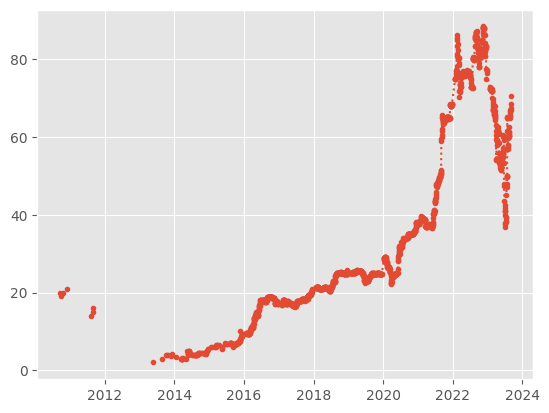

In [17]:
import matplotlib.pyplot as plt        
plt.plot(dates,prices, linestyle = 'dotted', marker='.')
plt.show()

Now crawl through individual web pages for stories we haven't got the price for, and attempt extracting the price from the summary. Note that we pause for 2 seconds after scraping each page, so this cell should take at least 840 seconds (14 minutes) to run through about 420 pages.

In [14]:
from scraping_functions import parse_summary

time0 = 0.0
cutoff_date = datetime(2016,2,22).date()
bad_date = datetime(2013,12,3).date()
for i in range(len(prices)):
    if prices[i] is None and dates[i] < cutoff_date and dates[i] != bad_date:
        tdiff = time.time() - time0
        if(tdiff < 2.0):
            time.sleep(2.0-tdiff)
        page = requests.get(url+hrefs[i])
        time0 = time.time()
        isoup = BeautifulSoup(page.content, "html.parser")
        
        # Extract the summary - the div element of class StoryFirstPara in soup
        para = isoup.find("div", class_="StoryFirstPara").text.strip()
        prices[i] = parse_summary(para)
        if(prices[i] is None):
            #print('Parsing 2nd para')
            para = isoup.find("div", class_="StorySecondPara").text.strip()
            prices[i] = parse_summary(para)        

Re-plot the data, and check the new number of price values in our list.

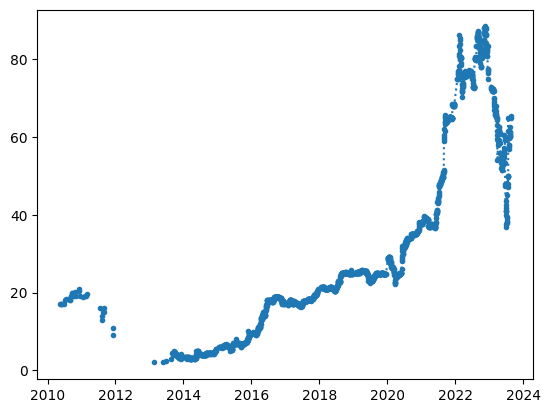

In [16]:
plt.plot(dates,prices,linestyle = 'dotted', marker='.')
plt.show()

In [17]:
print(len([price for price in prices if price is not None]))

2144


Save the price data to CSV file with links to source articles.

In [15]:
with open(datafile, 'w', newline='') as file:    
    writer = csv.writer(file)
    writer.writerow(['date','price','url'])
    for i in range(1,1+len(dates)):
        if(prices[-i] is not None):
            writer.writerow([dates[-i],prices[-i],url+hrefs[-i]])

## Scrapped code
Ignore everything below...

In [17]:
def parse_stories(hrefs):
    
    import requests
    from bs4 import BeautifulSoup
    from datetime import datetime
    
    data = []
    url_home="https://www.carbonnews.co.nz/"
    
    for href in hrefs:
        
        url = url_home+href
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        
        # Process the heading, which should be the first 'h1' element in soup
        h1elements = soup.find_all("h1", class_="story")
        heading = h1elements[0].text.strip()
        prices = [word.strip('$.') for word in heading.split() if word[0] == '$']
        if len(prices) == 1:
            price = prices[0]
        else:
            price = 'NaN'
            if len(price) > 1:
                print('WARNING: Heading contains multiple dollar values.')
            else:
                print('WARNING: Heading contains no dollar values.')        
            
        
        # Process text snippet, which should be the only div element of class StoryFirstPara in soup
        para = soup.find("div", class_="StoryFirstPara").text.strip()
        prices = [word.strip('$.') for word in para.split() if word[0] == '$']
        if price not in prices:
            print('WARNING: Heading price not in story text snippet.')
        
        # Process the story date
        h4elements = soup.find_all("h4")
        date = h4elements[0].text.strip()        
        if date.split()[0] == 'Today':
            date = datetime.today().strftime('%Y-%m-%d')
        else:
            date = ' '.join(date.split()[1:-1]) # strip weekday and time
            date = datetime.strptime(date,'%d %b %y').strftime('%Y-%m-%d')
        
        data.append({'date':date, 'price':price, 'url':url})
    
    return data